In [70]:
#### Global Variables

#SEIR Model with Social Distancing { run: "auto" }
# Reproduction number
R0 = 2.4
R0_low = 2.0 #lower reproduction number
R0_high = 2.8 #higher reproduction number

# Disease periods in days (t_incubation > t_infective)
t_incubation = 5.1
t_infective = 3.3 

# Disease periods in days (t_incubation < t_infective)
#t_incubation = 3.3
#t_infective = 5.1 

#Population Size
N = 14000
#Initial number exposed
n = 10 
# Start of social distancing following exposure (weeks)
t_social_distancing = 2
# Effectiveness of social distancing (0 to 100%)
u_social_distancing = 40 

In [71]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [72]:
# initial number of infected and recovered individuals

e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
beta_low = R0_low*gamma
beta_high = R0_high*gamma

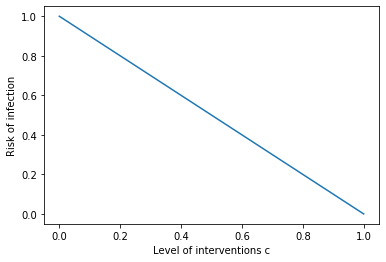

In [73]:
# linear risk of infection, sigma, of strategie,

def sigma_lin(c):
    return 1-c

c = np.linspace(0,1,3001)

plt.plot(c, sigma_lin(c))
plt.xlabel('Level of interventions c')
plt.ylabel('Risk of infection')
plt.show()

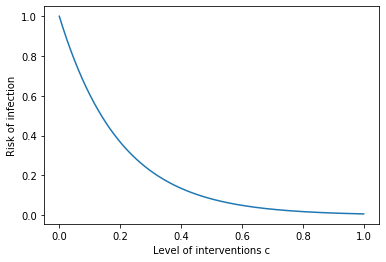

In [74]:
# exponential risk of infection, sigma, of strategie,

def sigma_exp(c):
    return math.e**(-5*c)

c = np.linspace(0,1,3001)

plt.plot(c, sigma_exp(c))
plt.xlabel('Level of interventions c')
plt.ylabel('Risk of infection')
plt.show()

In [75]:
def sigma(risk_of_infection,t):
    return risk_of_infection if t >= 7*t_social_distancing else 1

In [76]:
# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -sigma(sigma_lin(u/100),t)*beta * s * i
    dedt =  sigma(sigma_lin(u/100),t)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

In [77]:
#the strategie is set when the number of infections exceed infections_max

def determine_strategie(i, u, u_social_distancing, infections_max, t):
    if (i*N >= infections_max):
        #print('set interventions at level',u_social_distancing, 'i*N:',i*N, 't =',t)
        return u_social_distancing
    else: 
        return u

In [78]:
# SEIR model differential equations.
def deriv_flex(x, t, u, u_social_distancing, infections_max, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -sigma(sigma_lin( determine_strategie(i, u, u_social_distancing, infections_max, t)/100),t)*beta * s * i
    dedt =  sigma(sigma_lin( determine_strategie(i, u, u_social_distancing, infections_max, t)/100),t)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt = gamma * i
    return [dsdt, dedt, didt, drdt]

In [80]:
# A grid of time points (in days)
t_max = 365 # maximum number of days, e.g. until vaccination 
t = np.linspace(0, t_max, t_max+1)

x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T

#low reproduction number
s0_low, e0_low, i0_low, r0_low = odeint(deriv, x_initial, t, args=(0, alpha, beta_low, gamma)).T
#high reproduction number
s0_high, e0_high, i0_high, r0_high = odeint(deriv, x_initial, t, args=(0, alpha, beta_high, gamma)).T

s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

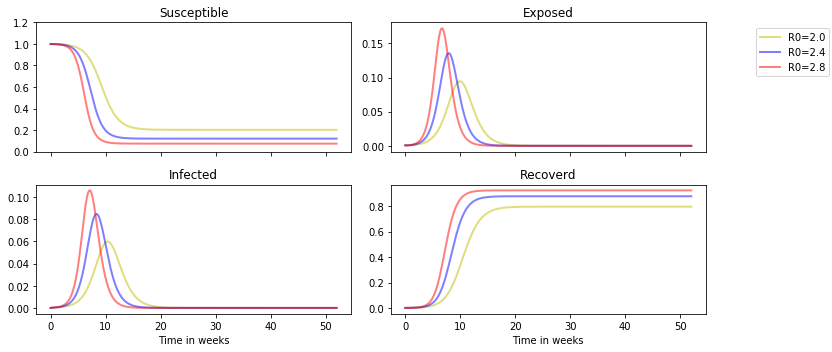

In [162]:
# Plot the data on four separate curves for S(t), E(t), I(t) and R(t)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,5))

t_last = 365

axs[0,0].set_ylim(0,1.2)
axs[0,0].set_title('Susceptible')
axs[0,0].plot(t[0:t_last]/7, s0_low[0:t_last], 'y', alpha=0.5, lw=2)
axs[0,0].plot(t[0:t_last]/7, s0[0:t_last], 'b', alpha=0.5, lw=2)
axs[0,0].plot(t[0:t_last]/7, s0_high[0:t_last], 'r', alpha=0.5, lw=2)

axs[0,1].set_title('Exposed')
axs[0,1].plot(t[0:t_last]/7, e0_low[0:t_last], 'y', alpha=0.5, lw=2)
axs[0,1].plot(t[0:t_last]/7, e0[0:t_last], 'b', alpha=0.5, lw=2)
axs[0,1].plot(t[0:t_last]/7, e0_high[0:t_last], 'r', alpha=0.5, lw=2)
axs[1,0].set_xlabel('Time in weeks')

axs[1,0].set_title('Infected')
axs[1,0].plot(t[0:t_last]/7, i0_low[0:t_last], 'y', alpha=0.5, lw=2)
axs[1,0].plot(t[0:t_last]/7, i0[0:t_last], 'b', alpha=0.5, lw=2)
axs[1,0].plot(t[0:t_last]/7, i0_high[0:t_last], 'r', alpha=0.5, lw=2)

axs[1,1].set_xlabel('Time in weeks')
axs[1,1].set_title('Recoverd')
l2 = axs[1,1].plot(t[0:t_last]/7, r0_low[0:t_last], 'y', alpha=0.5, lw=2, label='R0=2.0')
l1 = axs[1,1].plot(t[0:t_last]/7, r0[0:t_last], 'b', alpha=0.5, lw=2, label='R0=2.4')
l3 = axs[1,1].plot(t[0:t_last]/7, r0_high[0:t_last], 'r', alpha=0.5, lw=2, label='R0=2.8')

# Create the legend
fig.legend(
           borderaxespad=0,
           bbox_to_anchor=(1.05,0.9),
           loc="upper left"
           )

fig.tight_layout()

plt.savefig('different reproduction numbers.png', bbox_inches='tight')

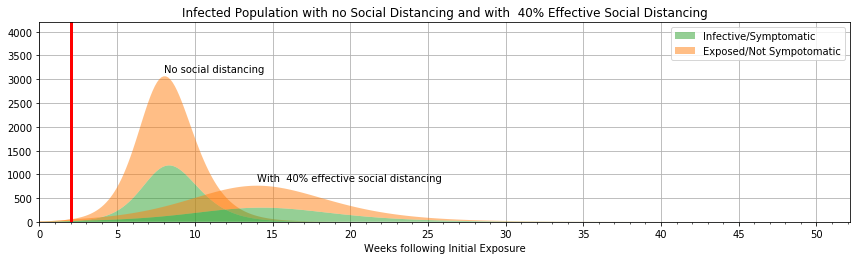

In [152]:
# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[0].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
#ax[0].stackplot(t/7, N*i_f, N*e_f, colors=pal[2:0:-1], alpha=0.5)
ax[0].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[0].set_xlabel('Weeks following Initial Exposure')
ax[0].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[0].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[0].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

#y_f = N*(e_f + i_f)
#k_f = np.argmax(y_f)
#ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,infections_max), (t[k_f]/7, y_f[k_f] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

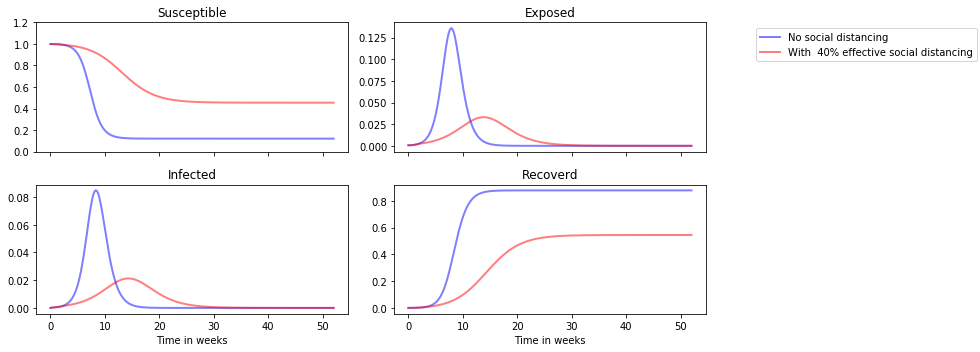

In [163]:
# Plot the data on two separate curves for S(t), E(t), I(t) and R(t)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,5))

t_last = 365

axs[0,0].set_ylim(0,1.2)
axs[0,0].set_title('Susceptible')
axs[0,0].plot(t[0:t_last]/7, s0[0:t_last], 'b', alpha=0.5, lw=2)
axs[0,0].plot(t[0:t_last]/7, s[0:t_last], 'r', alpha=0.5, lw=2)

axs[0,1].set_title('Exposed')
axs[0,1].plot(t[0:t_last]/7, e0[0:t_last], 'b', alpha=0.5, lw=2)
axs[0,1].plot(t[0:t_last]/7, e[0:t_last], 'r', alpha=0.5, lw=2)
axs[1,0].set_xlabel('Time in weeks')

axs[1,0].set_title('Infected')
axs[1,0].plot(t[0:t_last]/7, i0[0:t_last], 'b', alpha=0.5, lw=2)
axs[1,0].plot(t[0:t_last]/7, i[0:t_last], 'r', alpha=0.5, lw=2)

axs[1,1].set_xlabel('Time in weeks')
axs[1,1].set_title('Recoverd')
axs[1,1].plot(t[0:t_last]/7, r0[0:t_last], 'b', alpha=0.5, lw=2, label='No social distancing')
axs[1,1].plot(t[0:t_last]/7, r[0:t_last], 'r', alpha=0.5, lw=2, label='With {0:3.0f}% effective social distancing'.format(u_social_distancing))

# Create the legend
fig.legend(
           borderaxespad=0,
           bbox_to_anchor=(1.05,0.9),
           loc="upper left"
           )

fig.tight_layout()

plt.savefig('Flatten the curve SEIR.png', bbox_inches='tight')

In [119]:
x_initial_flex = s_initial, e_initial, i_initial, r_initial
infections_max = 500
s_f, e_f, i_f, r_f = odeint(deriv_flex, x_initial_flex, t, args=(0, u_social_distancing, infections_max, alpha, beta, gamma)).T

s_f_100, e_f_100, i_f_100, r_f_100 = odeint(deriv_flex, x_initial_flex, t, args=(0, u_social_distancing, 100, alpha, beta, gamma)).T
s_f_1000, e_f_1000, i_f_1000, r_f_1000 = odeint(deriv_flex, x_initial_flex, t, args=(0, u_social_distancing, 1000, alpha, beta, gamma)).T

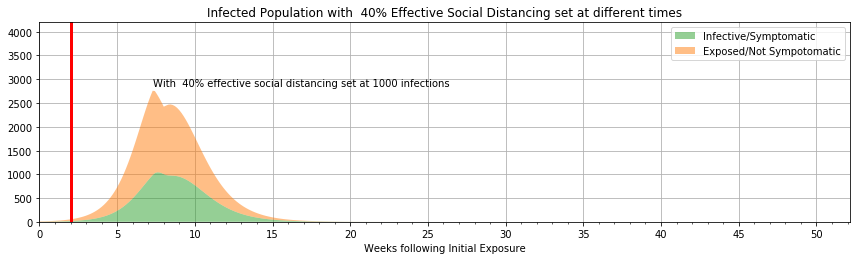

In [120]:
# plot the data using different maximum number of infections
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True)]

pal = sns.color_palette()

#ax[0].stackplot(t/7, N*i_f,N*e_f, colors=pal[2:0:-1], alpha=0.5)
#ax[0].stackplot(t/7, N*i_f_100, N*e_f_100, colors=pal[2:0:-1], alpha=0.5)
ax[0].stackplot(t/7, N*i_f_1000, N*e_f_1000, colors=pal[2:0:-1], alpha=0.5)
ax[0].set_title('Infected Population with {0:3.0f}% Effective Social Distancing set at different times'.format(u_social_distancing))
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[0].set_xlabel('Weeks following Initial Exposure')
ax[0].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

#y_f_100 = N*(e_f_100 + i_f_100)
#k_f_100 = np.argmax(y_f_100)
#ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,100), (t[k_f_100]/7, y_f_100[k_f_100] + 100))

y_f_1000 = N*(e_f_1000 + i_f_1000)
k_f_1000 = np.argmax(y_f_1000)
ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,1000), (t[k_f_1000]/7, y_f_1000[k_f_1000] + 100))

#y_f = N*(e_f + i_f)
#k_f = np.argmax(y_f)
#ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,infections_max), (t[k_f]/7, y_f[k_f] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

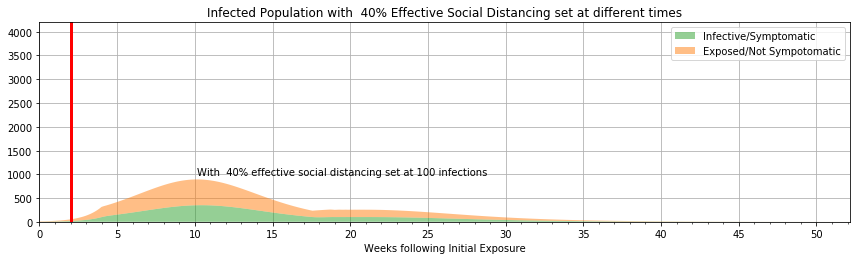

In [121]:
# plot the data using different maximum number of infections
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True)]

pal = sns.color_palette()

#ax[0].stackplot(t/7, N*i_f,N*e_f, colors=pal[2:0:-1], alpha=0.5)
ax[0].stackplot(t/7, N*i_f_100, N*e_f_100, colors=pal[2:0:-1], alpha=0.5)
#ax[0].stackplot(t/7, N*i_f_1000, N*e_f_1000, colors=pal[2:0:-1], alpha=0.5)
ax[0].set_title('Infected Population with {0:3.0f}% Effective Social Distancing set at different times'.format(u_social_distancing))
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[0].set_xlabel('Weeks following Initial Exposure')
ax[0].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y_f_100 = N*(e_f_100 + i_f_100)
k_f_100 = np.argmax(y_f_100)
ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,100), (t[k_f_100]/7, y_f_100[k_f_100] + 100))

#y_f_1000 = N*(e_f_1000 + i_f_1000)
#k_f_1000 = np.argmax(y_f_1000)
#ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,1000), (t[k_f_1000]/7, y_f_1000[k_f_1000] + 100))

#y_f = N*(e_f + i_f)
#k_f = np.argmax(y_f)
#ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,infections_max), (t[k_f]/7, y_f[k_f] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

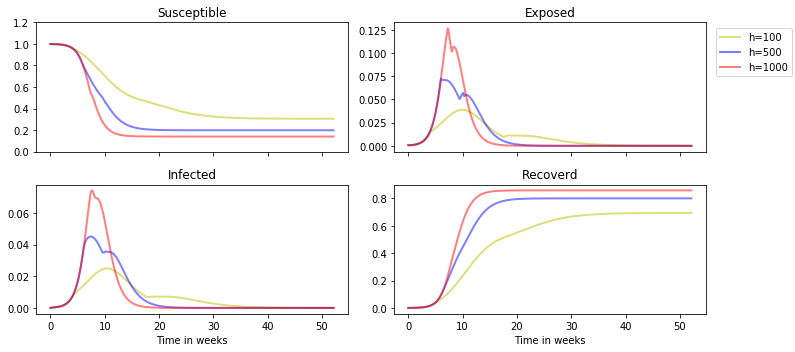

In [171]:
# Plot the data on four separate curves for S(t), E(t), I(t) and R(t)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,5))

axs[0,0].set_ylim(0,1.2)
axs[0,0].set_title('Susceptible')
axs[0,0].plot(t/7, s_f_100, 'y', alpha=0.5, lw=2)
axs[0,0].plot(t/7, s_f, 'b', alpha=0.5, lw=2)
axs[0,0].plot(t/7, s_f_1000, 'r', alpha=0.5, lw=2)

axs[0,1].set_title('Exposed')
axs[0,1].plot(t/7, e_f_100, 'y', alpha=0.5, lw=2)
axs[0,1].plot(t/7, e_f, 'b', alpha=0.5, lw=2)
axs[0,1].plot(t/7, e_f_1000, 'r', alpha=0.5, lw=2)
axs[1,0].set_xlabel('Time in weeks')

axs[1,0].set_title('Infected')
axs[1,0].plot(t/7, i_f_100, 'y', alpha=0.5, lw=2)
axs[1,0].plot(t/7, i_f, 'b', alpha=0.5, lw=2)
axs[1,0].plot(t/7, i_f_1000, 'r', alpha=0.5, lw=2)

axs[1,1].set_xlabel('Time in weeks')

axs[1,1].set_title('Recoverd')
l2 = axs[1,1].plot(t/7, r_f_100, 'y', alpha=0.5, lw=2, label='h=100')
l1 = axs[1,1].plot(t/7, r_f, 'b', alpha=0.5, lw=2, label='h=500')
l3 = axs[1,1].plot(t/7, r_f_1000, 'r', alpha=0.5, lw=2, label='h=1000')

# Create the legend
fig.legend(borderaxespad=0,
           loc='upper right',
           bbox_to_anchor=(1.1, 0.9)   # Small spacing around legend box
           )


fig.tight_layout()
plt.savefig('SEIR effects of social distancing strategies.png', bbox_inches='tight')